Data preparation

In [3]:
import os
from glob import glob
import pandas as pd 

base_skin_dir = os.path.join('..', 'input/skin-cancer-mnist-ham10000')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

Remove null

In [4]:
skin_df.isnull().sum()
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df.isnull().sum()
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


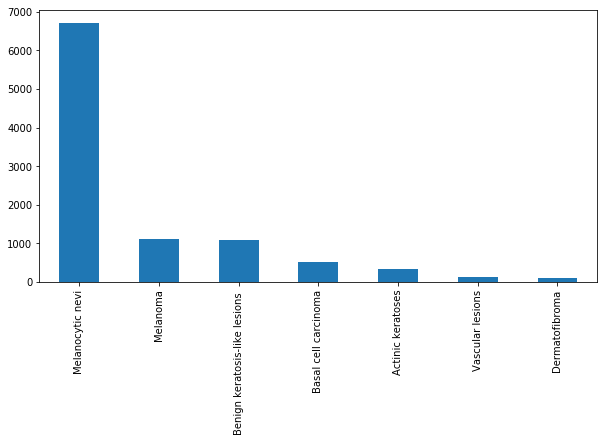

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

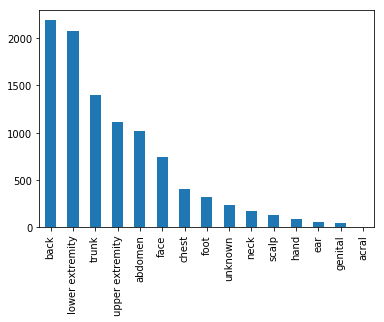

In [6]:
skin_df['localization'].value_counts().plot(kind='bar')

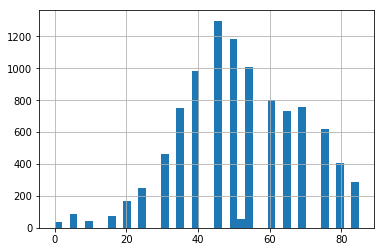

In [7]:
skin_df['age'].hist(bins=40)

Resize images

In [8]:
import numpy as np
from PIL import Image
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((128,96))))

## Samples of Images

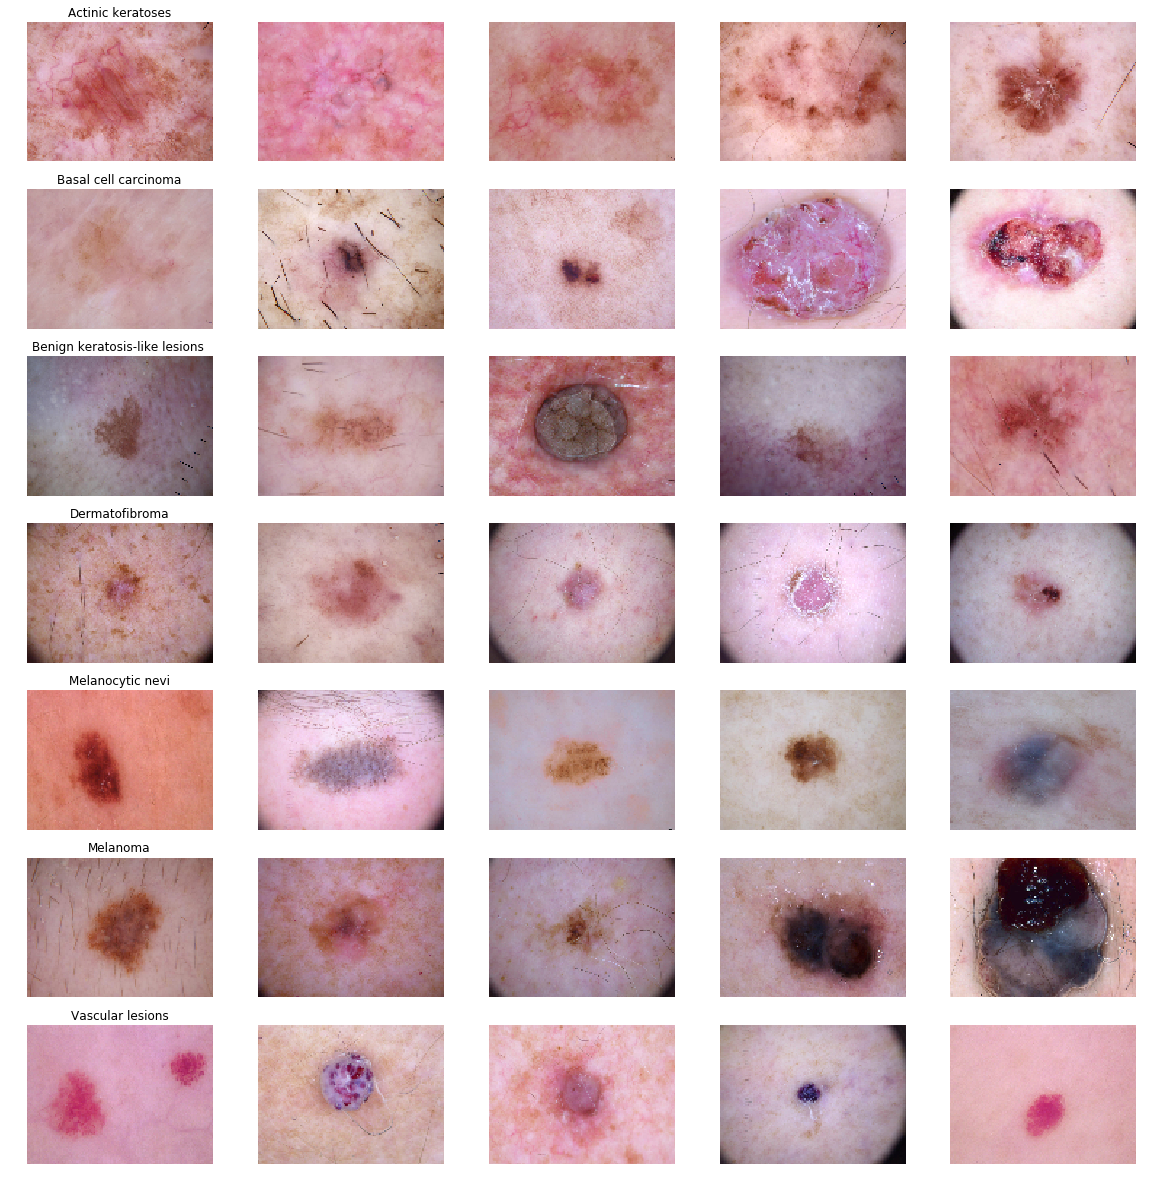

In [9]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [10]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(96, 128, 3)    10015
Name: image, dtype: int64

Set features and target

In [11]:
features = skin_df.drop(columns=['cell_type_idx'],axis=1)
target = skin_df['cell_type_idx']

Split training set 90/10

In [12]:
from sklearn.model_selection import train_test_split
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.30,random_state=1234)

Normalization

In [13]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

### Label encoding
Labels are 7 different classes of skin cancer types from 0 to 6

In [14]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

Using TensorFlow backend.


## Split Training and Validation
70/30

In [15]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.3, random_state = 2)

Reshape images into 3 dimensions

In [16]:
x_train = x_train.reshape(x_train.shape[0], *(96, 128, 3))
x_test = x_test.reshape(x_test.shape[0], *(96, 128, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(96, 128, 3))

Data Augmentation

In [17]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

Transfer learning

# Train Model

In [26]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

CLASSES = 7
EPOCHS = 10
BATCH_SIZE = 10

# create the base pre-trained model
from keras.applications.vgg16 import VGG16

# Replace the 'weights' argument with the local path to the weights file
# base_model = VGG16(weights=r'C:\Users\muham\Documents\VGG16 weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)
weights_path = '/kaggle/input/vgg16-weights/tensorflow2/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Create the base VGG16 model without the top layer
base_model = VGG16(weights=None, include_top=False)

# Load the weights from the file
base_model.load_weights(weights_path)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(128, activation='relu')(x)
# add Dropout layer to reduce overfitting
x = Dropout(0.2)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(CLASSES, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# train the model on the new data for a few epochs
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=BATCH_SIZE),
                              epochs = EPOCHS, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // BATCH_SIZE
                              , callbacks=[learning_rate_reduction])

Epoch 1/10
490/490 [==============================] - 472s 963ms/step - loss: 0.9478 - accuracy: 0.6792 - val_loss: 0.8278 - val_accuracy: 0.7028
Epoch 2/10
490/490 [==============================] - 473s 966ms/step - loss: 0.8170 - accuracy: 0.7104 - val_loss: 0.8041 - val_accuracy: 0.7142
Epoch 3/10
490/490 [==============================] - 472s 963ms/step - loss: 0.7806 - accuracy: 0.7219 - val_loss: 0.7662 - val_accuracy: 0.7328
Epoch 4/10
490/490 [==============================] - 472s 963ms/step - loss: 0.7537 - accuracy: 0.7331 - val_loss: 0.8043 - val_accuracy: 0.7247
Epoch 5/10
490/490 [==============================] - 473s 965ms/step - loss: 0.7388 - accuracy: 0.7313 - val_loss: 0.7973 - val_accuracy: 0.7256
Epoch 6/10
490/490 [==============================] - 472s 964ms/step - loss: 0.7311 - accuracy: 0.7347 - val_loss: 0.7468 - val_accuracy: 0.7356
Epoch 7/10
490/490 [==============================] - 470s 960ms/step - loss: 0.7051 - accuracy: 0.7478 - val_loss: 0.7932 -

In [27]:
# Save the entire model to an H5 file
model.save('/kaggle/working/vgg16_skin_disease_model.h5')


In [2]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:

for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

NameError: name 'base_model' is not defined

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:-2]:
   layer.trainable = False
for layer in model.layers[-2:]:
   layer.trainable = True

In [ ]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

Fine-tune top 2 layers

In [ ]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history1 = model.fit_generator(datagen.flow(x_train,y_train, batch_size=BATCH_SIZE))

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# Results

In [ ]:
plot_model_history(history)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

# Validate

In [ ]:






from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input


img_list = [
    skin_df['image'][6410],
    skin_df['image'][2310],
    skin_df['image'][1530],
    skin_df['image'][4191],
    skin_df['image'][1],
]

validation_batch = np.stack([preprocess_input(img) for img in img_list])
    
pred = model.predict(validation_batch)
for p in pred:
    print(list(map(lambda x: x * 100, p)))

In [ ]:
import numpy as np

classes = [
    'Melanocytic nevi',
    'Melanoma',
    'Benign keratosis-like lesions ',
    'Basal cell carcinoma',
    'Actinic keratoses',
    'Vascular lesions',
    'Dermatofibroma'
]

fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    p_idx = np.argmax(pred[i])
    title = "{:.0f}%: {:}".format(100*pred[i,p_idx], classes[p_idx])
    ax.set_title(title)
    ax.imshow(img)